In [46]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import beta as B
from scipy.special import betaln as lnB

In [47]:
data = np.loadtxt('binarydigits.txt')

Question 1

In [48]:
def learn_pML(data):
    N, D = data.shape
    pML = (1/N)*np.sum(data, axis=0)
    return pML

def learn_pMAP(data, alpha, beta):
    N, D = data.shape
    pML = learn_pML(data)
    pMAP = (pML + alpha - 1)/(alpha + beta - 1)
    return pMAP

def plot_pixels(data, title=''):
    plt.figure()
    plt.imshow(np.reshape(data, (8,8)), vmin=0, vmax=1, interpolation='None', cmap='grey')
    plt.title(title)


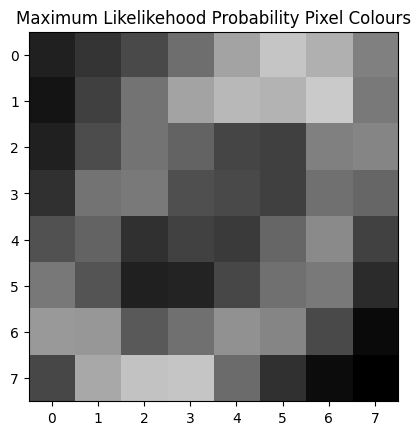

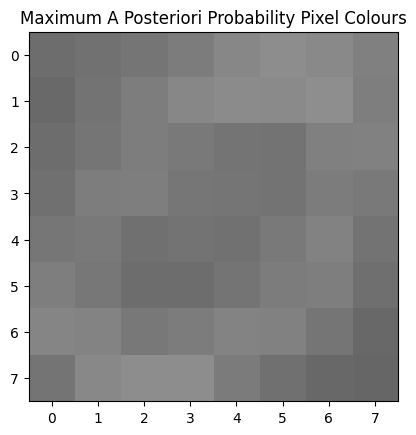

In [49]:
pML = learn_pML(data)
plot_pixels(pML, "Maximum Likelikehood Probability Pixel Colours")

pMAP = learn_pMAP(data, 3.0, 3.0)
plot_pixels(pMAP, "Maximum A Posteriori Probability Pixel Colours")

Question 2

In [50]:
N, D = map(int, data.shape)

alpha = 1 + np.sum(data)
beta = N*D + 1 - alpha
alpha_d = 1 + np.sum(data, axis=0)
beta_d = N - alpha_d

log_prob_model_a = N*D*np.log((0.5))
log_prob_model_b = lnB(alpha, beta)
log_prob_model_c = np.sum(lnB(alpha_d, beta_d))

avg_log_prob_model = np.mean([log_prob_model_a, log_prob_model_b, log_prob_model_c])

rel_prob_model_a = np.exp(log_prob_model_a - avg_log_prob_model)
rel_prob_model_b = np.exp(log_prob_model_b - avg_log_prob_model)
rel_prob_model_c = np.exp(log_prob_model_c - avg_log_prob_model)

# print('log_prob_model_a : log_prob_model_b : log_prob_model_c = ', log_prob_model_a, ':', log_prob_model_b, ':', log_prob_model_c)

print('(relative) prob_model_a : prob_model_b : prob_model_c = ', rel_prob_model_a, ':', rel_prob_model_b, ':', rel_prob_model_c)

(relative) prob_model_a : prob_model_b : prob_model_c =  3.79475594665626e-118 : 9.755326203651874e-52 : 2.701309548088313e+168


Question 3

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
data = np.loadtxt('binarydigits.txt')

In [376]:
def param_init(K, X):
    """
    K   : scalar representing number of mixtures
    X   : NxD matrix of data points
    pi  : 1xK vector of mixture fractions
    P   : KxD matrix of parameters
    """
    _, D = X.shape
    pi = np.ones(K)/K
    P = np.random.rand(K, D)
    P = np.clip(P, 1e-10, 1-1e-10)
    return pi, P

def calc_log_likelihood(pi, P, X):
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    l       : NxK matrix of log likelihood values
    """
    l = X@np.log(P).T + (1-X)@np.log(1-P).T
    return l

def update_log_r(pi, P, X):
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    r       : NxK matrix of responsibilities
    """
    log_likelihood = calc_log_likelihood(pi, P, X)
    log_prior = np.log(pi)[None, :]
    log_prob = log_likelihood + log_prior
    mixture_log_likelihood = logsumexp(log_prob, axis=1, keepdims=True)

    log_r = log_prob - mixture_log_likelihood
    total_log_likelihood = np.sum(mixture_log_likelihood)
    return log_r, total_log_likelihood

def update_P_d(r, X_d):
    """
    r       : NxK matrix of responsibilities   
    X_d     : Nx1 vector of Dth column of data points in X
    P_d     : Kx1 vector of Dth column of parameters in P
    """
    num = r.T@X_d
    den = np.sum(r, axis = 0)
    P_d = num/den
    return P_d


def update_pi(r, X):
    """
    r   : NxK matrix of responsibilities
    X   : NxD matrix of data points
    pi  : 1xK vector of mixture fractions
    """
    N, _ = X.shape
    pi = np.sum(r, axis=0)/N
    return pi


def e_step(pi, P, X):
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    r       : NxK matrix of responsibilities
    total_l : scalar value representing total mixture log likelihood
    """
    log_r, total_l = update_log_r(pi, P, X)
    r = np.exp(log_r)
    return r, total_l


def m_step(r, X):
    """
    r       : NxK matrix of responsibilities
    X       : NxD matrix of data points
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    """
    pi = update_pi(r, X)
    _, D = X.shape
    _, K = r.shape
    P = np.zeros((K, D))
    for d in range(D):
        P[:, d] = update_P_d(r, X[:, d])
    P = np.clip(P, 1e-10, 1-1e-10)
    return pi, P


def em_run(K, X, max_iter=200, tol=1e-10):
    """
    K       : scalar representing number of mixtures
    X       : NxD matrix of data points
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    total_l : scalar value representing total mixture log likelihood
    i       : scalar representing number of completed iterations
    """
    pi, P = param_init(K, X)
    l_history = []
    delta = np.inf
    total_l_prev = -np.inf
    i = 0
    while i<max_iter and delta>tol:
        r, total_l = e_step(pi, P, X)
        pi, P = m_step(r, X)
        delta = total_l - total_l_prev
        l_history += [total_l]
        total_l_prev = total_l
        i += 1
    return pi, P, r, total_l, i, l_history


Number of Mixtures: 2
Iterations Completed: 19
Final Log Likelihood: -3303.590612396685
Mixture weights: [0.41963514 0.58036486]

Number of Mixtures: 3
Iterations Completed: 9
Final Log Likelihood: -3049.950505341145
Mixture weights: [0.3400003  0.40999871 0.25000099]

Number of Mixtures: 4
Iterations Completed: 12
Final Log Likelihood: -2830.374847025023
Mixture weights: [0.19998454 0.43000011 0.15999998 0.21001537]

Number of Mixtures: 7
Iterations Completed: 16
Final Log Likelihood: -2587.6919606946026
Mixture weights: [0.26000052 0.03999997 0.01       0.13013859 0.24986091 0.15       0.16      ]

Number of Mixtures: 10
Iterations Completed: 17
Final Log Likelihood: -2326.5339216984316
Mixture weights: [0.05999981 0.03       0.22999979 0.17       0.15       0.02       0.03       0.18003136 0.07996904 0.05      ]

[4767, 4401, 4084, 3734, 3357]


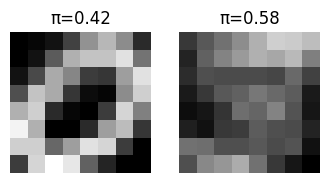

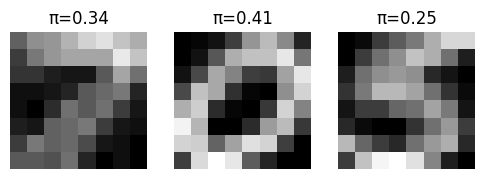

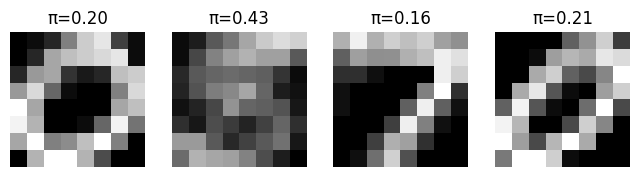

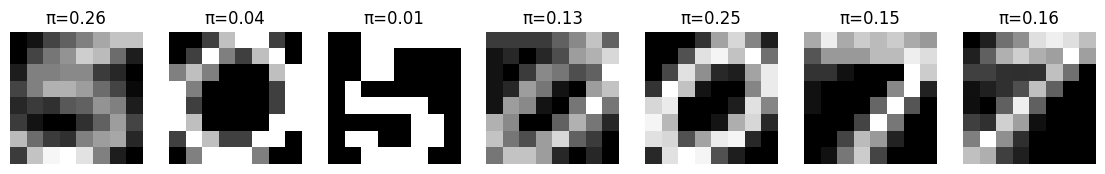

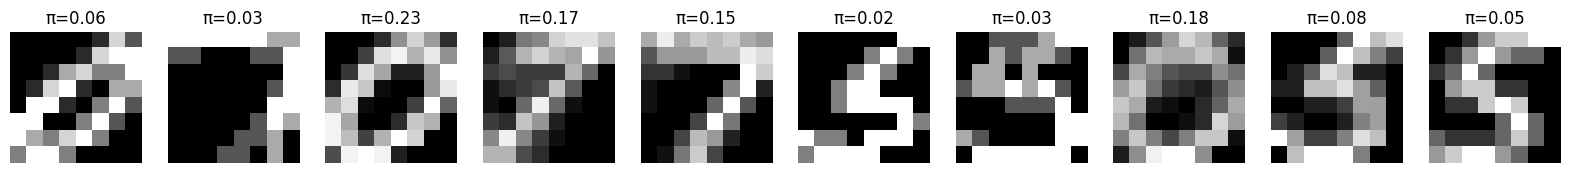

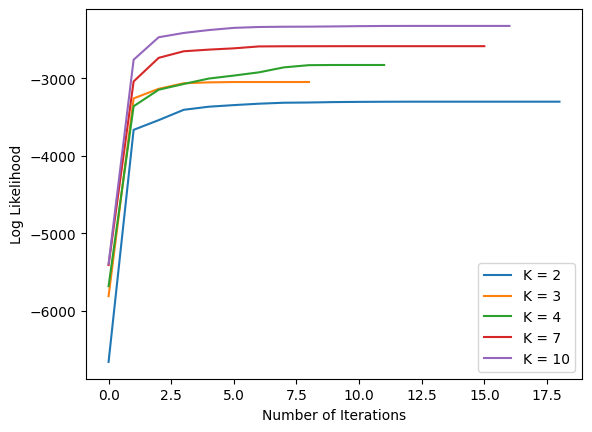

In [406]:
np.set_printoptions(linewidth=200)

mixtures = {2, 3, 4, 7, 10}
bits = []
plt.figure(1)
for K in mixtures:
    pi, P, r, log_likelihood, iteration, l_history = em_run(K, data)

    bits += [int(np.ceil(-log_likelihood/np.log(2)))]
    print('Number of Mixtures: ' + str(K))
    print('Iterations Completed:', iteration)
    print('Final Log Likelihood:', log_likelihood)
    print('Mixture weights:', pi)
    print("")

    plt.figure(figsize=(2*K, 3))
    for k in range(K):
        plt.subplot(1, K, k+1)
        plt.imshow(P[k].reshape(8,8), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
        plt.title(f"π={pi[k]:.2f}")
        plt.axis('off')

    plt.figure(1)
    plt.plot(l_history, label='K = ' + str(K))
    plt.ylabel('Log Likelihood')
    plt.xlabel('Number of Iterations')
    plt.legend(loc = 'lower right')




print(bits)

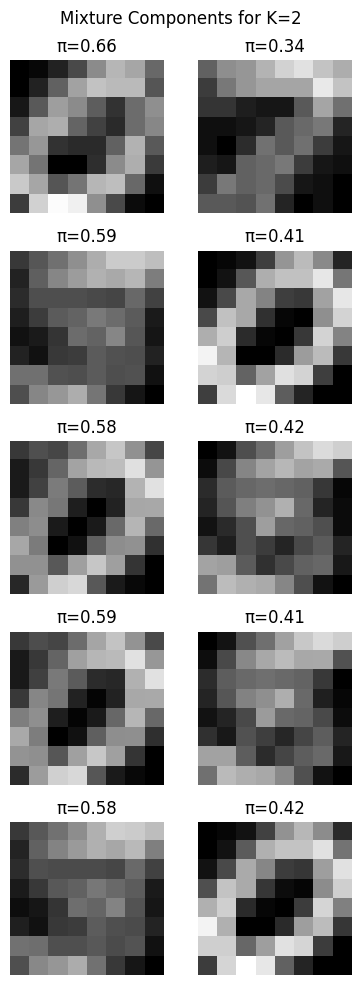

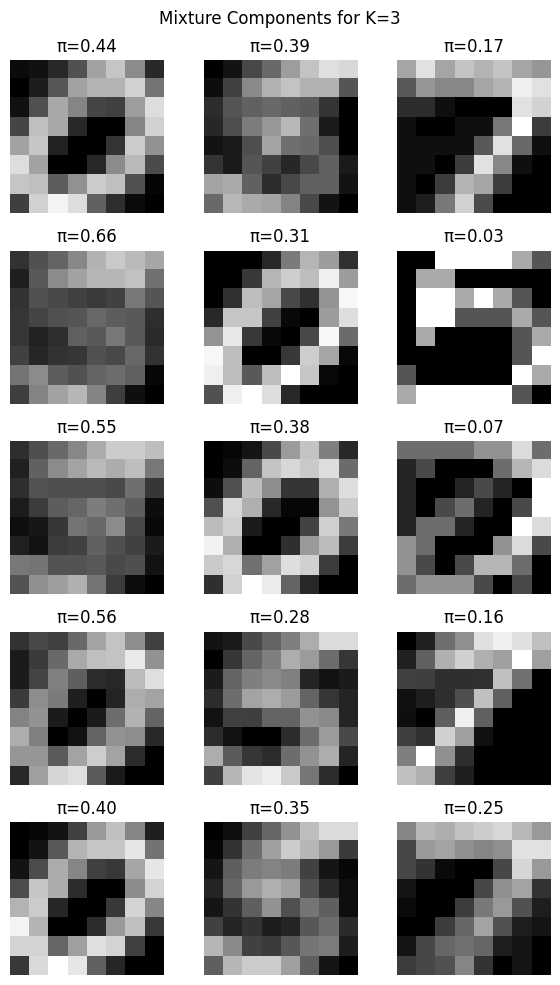

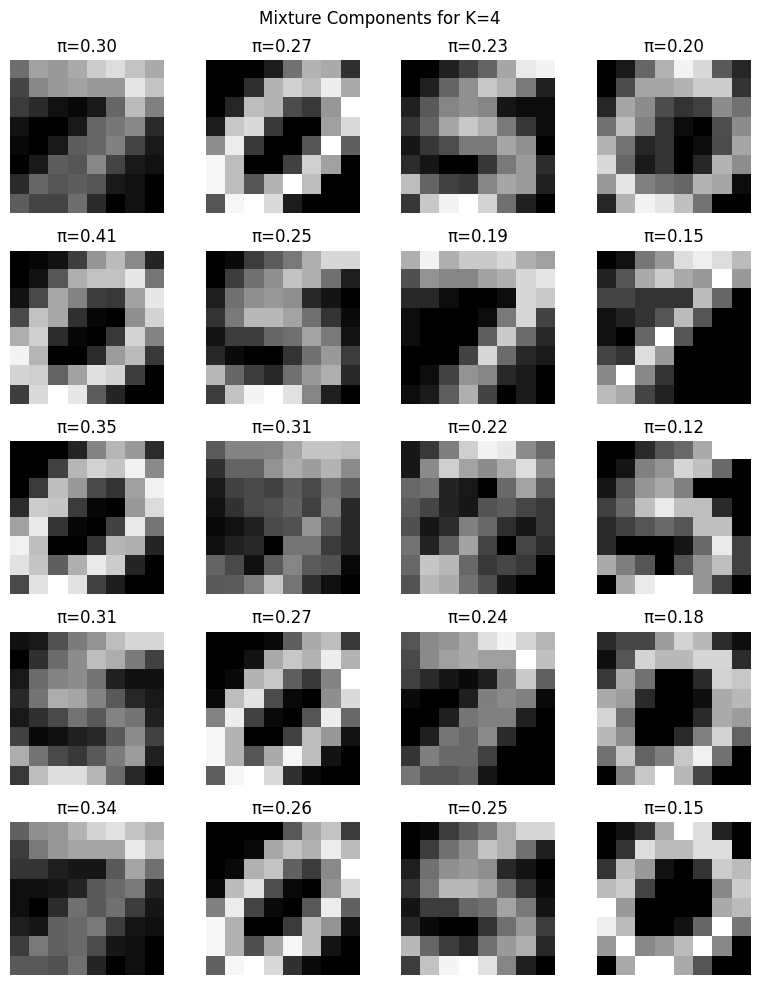

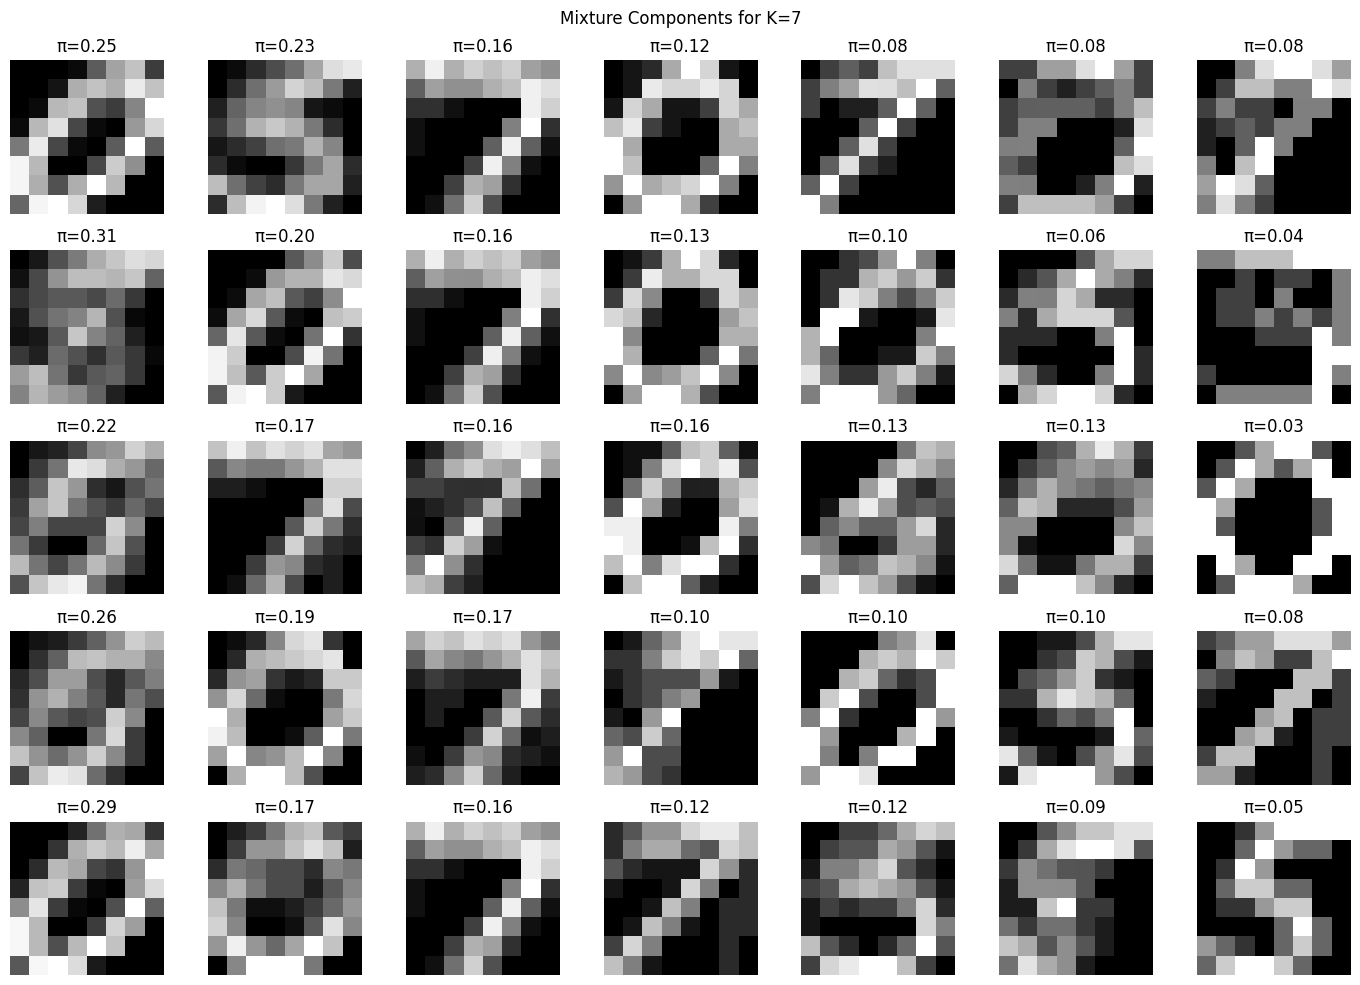

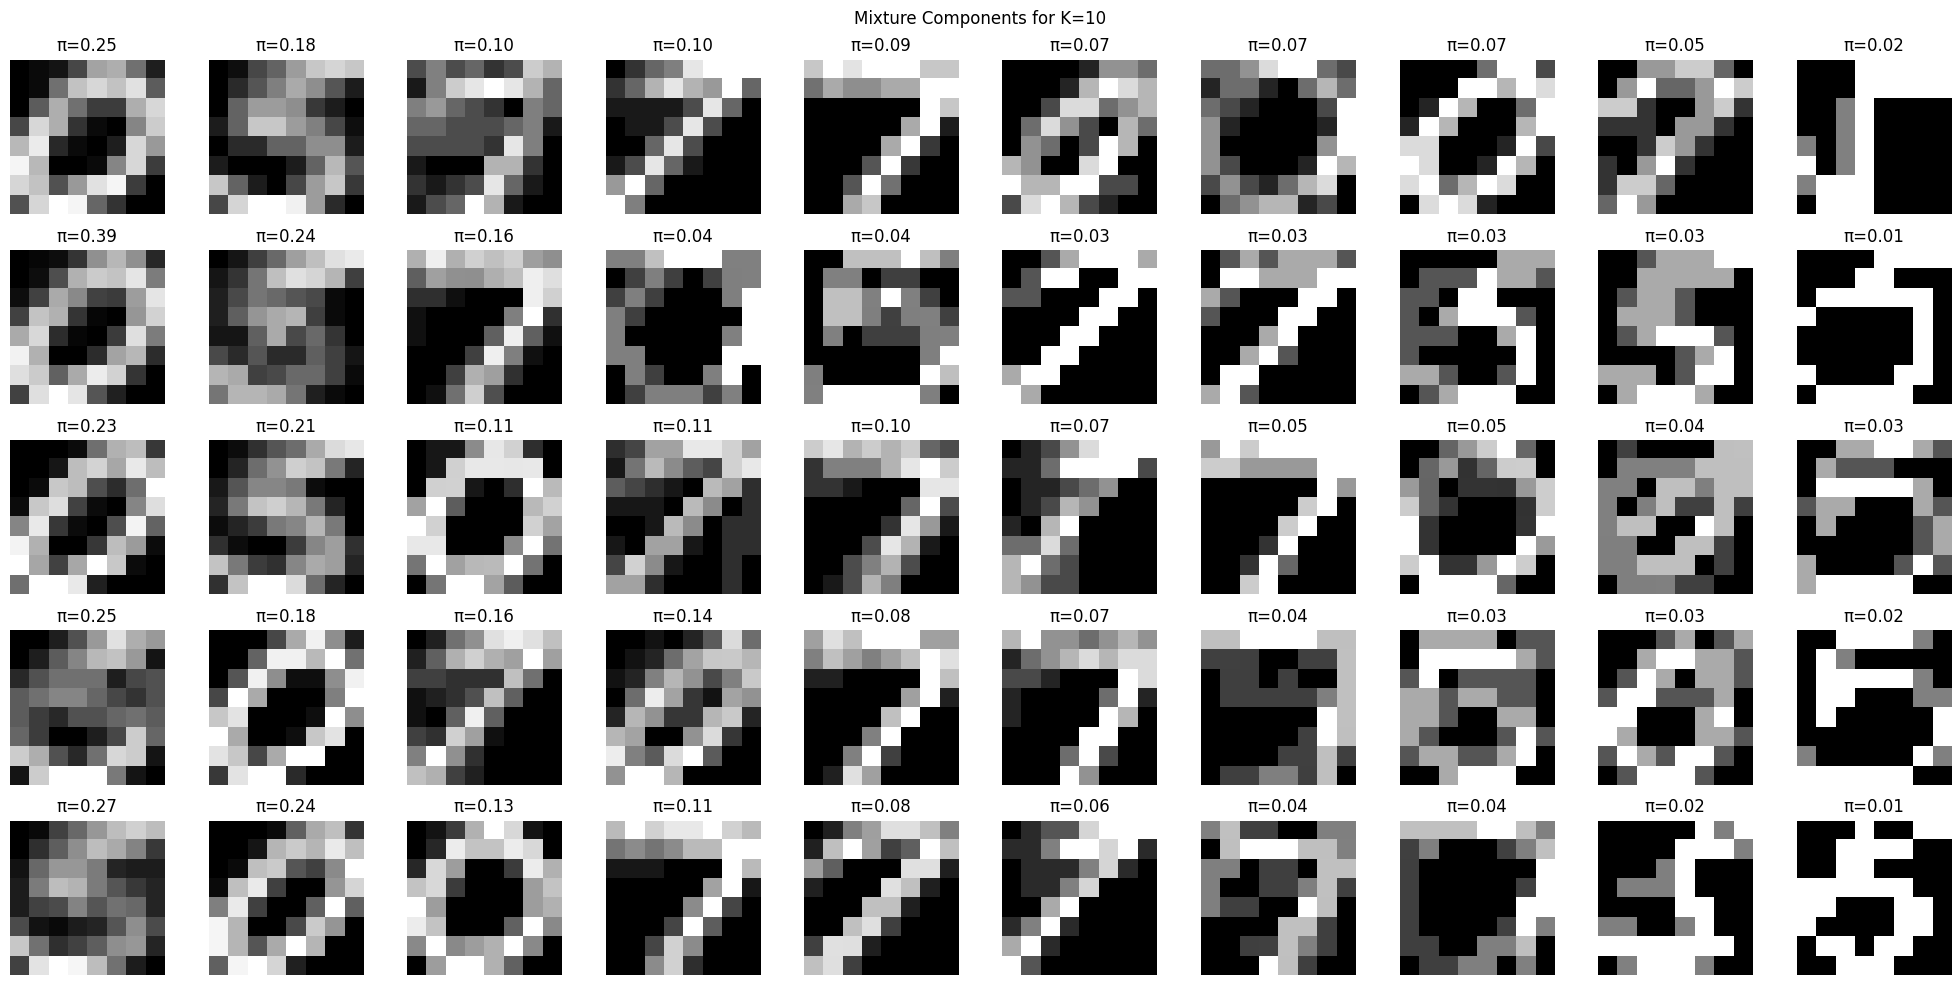

In [ ]:
n_repeats = 5

for K in mixtures:
    plt.figure(figsize=(2*K, 2*n_repeats))
    for repeat in range(n_repeats):
        pi, P, r, ll, it, _ = em_run(K, data)

        order = np.argsort(-pi)              # indices of π in descending order
        pi = pi[order]                       # reorder π
        P = P[order, :]                      # reorder component probability images

        for k in range(K):
            idx = repeat*K + k + 1
            plt.subplot(n_repeats, K, idx)
            plt.imshow(P[k].reshape(8,8), cmap='gray', vmin=0, vmax=1)
            plt.title(f"π={pi[k]:.2f}")
            plt.axis('off')

    plt.suptitle(f"Mixture Components for K={K}")
    plt.tight_layout()
    plt.show()

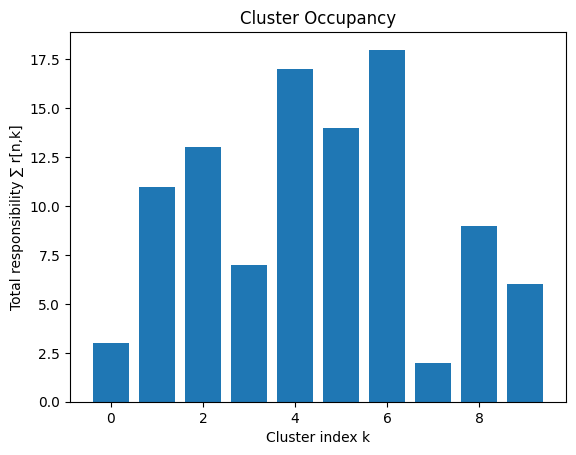

In [379]:
cluster_mass = r.sum(axis=0)   # length K
plt.bar(range(len(cluster_mass)), cluster_mass)
plt.xlabel("Cluster index k")
plt.ylabel("Total responsibility ∑ r[n,k]")
plt.title("Cluster Occupancy")
plt.show()

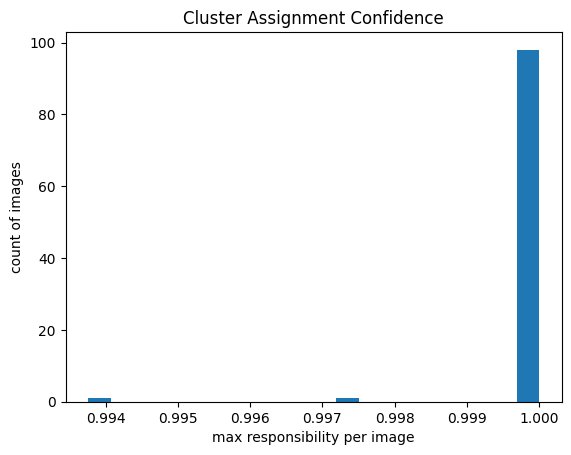

In [380]:
conf = r.max(axis=1)
plt.hist(conf, bins=20)
plt.xlabel("max responsibility per image")
plt.ylabel("count of images")
plt.title("Cluster Assignment Confidence")
plt.show()

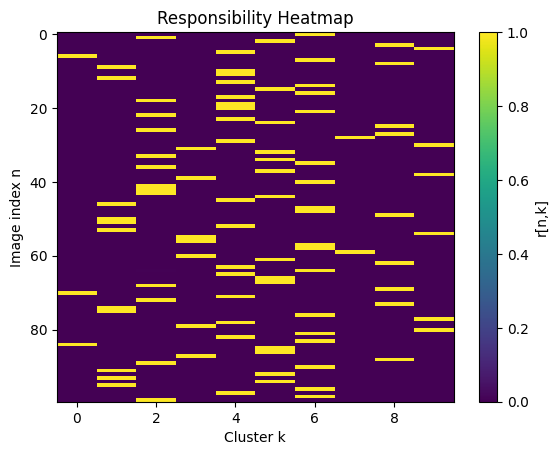

In [381]:
plt.imshow(r, aspect='auto', cmap='viridis')
plt.colorbar(label="r[n,k]")
plt.xlabel("Cluster k")
plt.ylabel("Image index n")
plt.title("Responsibility Heatmap")
plt.show()

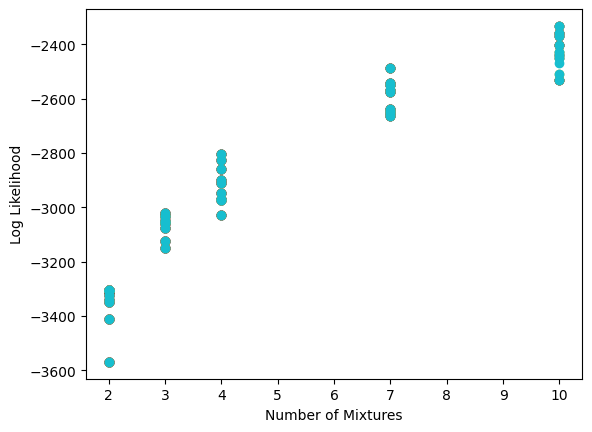

In [ ]:
mixtures = {2, 3, 4, 7, 10}
bits = []
ll_arr = []
K_arr = []
plt.figure()
for K in mixtures:
    for repeat in range(10):
        pi, P, log_likelihood, iteration, l_history = em_run(K, data)
        ll_arr += [log_likelihood]
        K_arr += [K]
        bits += [int(np.ceil(-log_likelihood/np.log(2)))]
        plt.scatter(K_arr, ll_arr)
        plt.ylabel('Log Likelihood')
        plt.xlabel('Number of Mixtures')